# BDC2020 Reto México
## Luis Fernando Pardo Sixtos
## Andrea Monserrat Ruiz Gómez

Este es el código con el que obtuvimos nuestro mejor resultado. Se trata de una versión modificada de k-medias con las siguientes particularidades:

* Acepta puntos repetidos, pero no permite que se encuentren en el mismo cluster.
* A partir de una iteración dada se balancea la cantidad de clientes por zona, dispersando el excedente de clientes de manera aleatoria, dando preferencia a los clusters con menos clientes.
* A partir de una iteración dada se balancea la cantidad de clientes por zona, dispersando el excedente de volumen (clientes) de manera aleatoria, dando preferencia a los clusters con menos volumen.
* Cada vez que se va a ejecutar algún balanceo se evalua las métricas de nodos y volumen, se construye un frente de pareto utilizando estas dos cantidades. Si el acomodo actual entra en el frente de pareto, se guarda para más tarde.
* Cada determinado número de oraciones se reinician los centros con alguno de los acomodos con resultados en el frente de pareto.
* Este algoritmo no ofrece una sola solución, sino un arreglo de soluciones con los mejores valores encontrados para las restricciones solicitadas.

El algoritmo está implementando utilizando la paquetería de pytorch, permitiendo una ejecución eficiente de operaciones matriciales y su uso en equipos con CUDA.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn.functional as F
import sklearn
import sklearn.cluster.k_means_
import numpy as np
from sklearn.utils.extmath import row_norms, squared_norm
from sklearn.utils import check_random_state
import copy
import random
import time

C:\Users\lpard\Anaconda3\envs\BDC\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [8]:
def evaluate_metrics(clusters, vols):
    num_nodes = torch.cat([torch.sum(clusters==i, dim=0, keepdim=True) for i in range(6)],dim=0)
    total_volumes = torch.cat([torch.sum(vols[clusters==i], dim=0, keepdim=True) for i in range(6)],dim=0)
    return num_nodes.float().std().item(), total_volumes.std().item()

In [9]:
def balance_cluster(diffs, clusters, max_nodes):
    '''Función para balancear el número de nodos de un cluster'''
    num_nodes = torch.cat([torch.sum(clusters==i, dim=0, keepdim=True) for i in range(6)],dim=0)
    for c_num, total in enumerate(num_nodes):
        if total>max_nodes:
            extra = total-max_nodes
            probs_single = F.softmax(diffs, dim=1)
            real_indices = torch.arange(clusters.shape[0])
            real_indices = real_indices[clusters==c_num]
            probs_single = probs_single[clusters==c_num]
            probs_global = F.softmax(1-probs_single[:,c_num], dim=0)
            samples = torch.multinomial(probs_global, extra.item())
            real_indices = real_indices[samples]
    #         probs_single = probs_single[samples]
            samples = torch.multinomial(F.softmax(-num_nodes.float(), dim=0), extra, replacement=True)
            clusters[real_indices] = samples
    return clusters

In [10]:
def balance_cluster_volume(diffs, clusters, max_vol, vols):
    '''Función para balancear el volumen de los clusters.'''
    total_volumes = torch.cat([torch.sum(vols[clusters==i], dim=0, keepdim=True) for i in range(6)],dim=0)
    for c_num, total in enumerate(total_volumes):
        if total>max_vol:
            extra = ((total-max_vol)/vols.mean()).int()+1
            probs_single = F.softmax(diffs, dim=1)
            real_indices = torch.arange(clusters.shape[0])
            real_indices = real_indices[clusters==c_num]
            probs_single = probs_single[clusters==c_num]
            probs_global = F.softmax(1-probs_single[:,c_num], dim=0)
            samples = torch.multinomial(probs_global, extra.item())
            real_indices = real_indices[samples]
    #         probs_single = probs_single[samples]
            samples = torch.multinomial(F.softmax(-total_volumes.float(), dim=0), extra, replacement=True)
            clusters[real_indices] = samples
    return clusters

In [11]:
def assign_points(centers, data, flags, vols = None, balance_nodes=False):
    '''Función para asignar los datos a los clusters'''
    data_ = data.unsqueeze(2)
    centers_ = centers.unsqueeze(0).permute(0, 2, 1)
    diffs = (data_-centers_)**2
    diffs = diffs.sum(1)
    sorted_diffs, indices = diffs.sort(1)
    
    # Puntos repetidos no pueden pertenecer al mismo cluster
    clusters = indices[:,0]
    clusters[flags==2] = indices[flags==2,1]
    clusters[flags==3] = indices[flags==3,2]
    
    # Ejecuta los balanceos con probabilidad de 1/3
    nodes_std, vol_std = None, None
    rand = np.random.randint(3)
    if balance_nodes:
        if rand ==1:
            clusters = balance_cluster(diffs, clusters, clusters.shape[0]//centers.shape[0])
        elif rand==2:
            clusters = balance_cluster_volume(diffs, clusters, vols.sum()/6, vols)
        else:
            nodes_std, vol_std = evaluate_metrics(clusters, vols)
    return clusters, nodes_std, vol_std

In [12]:
def kiter(centers, data, flags, vols, balance_nodes=False, balance_volume=False):
    '''Iteración del algoritmo de kmedias modificado'''
    clusters, nodes_std, vol_std = assign_points(centers, data, flags, vols, balance_nodes)
    for i in range(centers.shape[0]):
        centers[i] = data[clusters==i].mean(0)
    if nodes_std is not None:
        return centers, clusters, nodes_std, vol_std
    return centers, None, None, None

In [13]:
# Inicialización de banderas que indican los nodos que aparecen por segunda o tercera vez
flags = []
for f in data['Frecuencia']:
    flags.append(1)
    if f >1:
        flags.append(2)
    if f>2:
        flags.append(3)
flags = torch.tensor(flags)

In [14]:
# Matriz de volumen
vols = torch.tensor(data['Vol_Entrega'].to_numpy().repeat(data['Frecuencia']))

In [23]:
#Lectura y normalizción de los datos
data = pd.read_csv('ubicaciones.csv')
scaler = StandardScaler()
points = scaler.fit_transform(data[['lat', 'lon']].to_numpy())
points = points.repeat(data['Frecuencia'].to_numpy(), axis=0)

# for iters in range(20, 200, 5):
#Permite diferentes pruebas con distinto número de iteraciones
iters = 1000
#Inicialización de frente de pareto
pareto_front = []
pareto_data = []

#Inicialización de los centroides utilizando k-means++
n_clusters = 6
random_state = None
random_state = check_random_state(random_state)
x_squared_norms = row_norms(points, squared=True)
centers = sklearn.cluster.k_means_._k_init(points, n_clusters, random_state=random_state,x_squared_norms=x_squared_norms)
centers = torch.tensor(centers)

# Iteraciones del algoritmo, a partir de la iteración 5 se añaden los operadores aleatorios
points = torch.tensor(points)
balance_clusters=False
for i in range(iters):
    if i==5:
        balance_clusters=True
    centers, clusters, nodes_std, vol_std = kiter(centers, points, flags, vols, balance_clusters)

    if nodes_std is not None:
        signs = [(info[0]-nodes_std)*(info[1]-vol_std)>=0 for info in pareto_front]
        if np.sum(signs) == 0:
            if len(pareto_front)==100:
                rand = np.random.randint(100)
                pareto_front[r] = (nodes_std, vol_std)
                pareto_data[r] = (copy.deepcopy(centers), copy.deepcopy(clusters))
            else:
                pareto_front.append((nodes_std, vol_std))
                pareto_data.append((copy.deepcopy(centers), copy.deepcopy(clusters)))
        elif np.sum(signs)>0:
            dominated = [info for info in pareto_front if info[0]>=nodes_std and info[1]>=vol_std]
            if len(dominated)>0:
                pareto_front = [info for info in pareto_front if not(info[0]>=nodes_std and info[1]>=vol_std)]
                pareto_data = [p_data for info, p_data in zip(pareto_front,pareto_data) if not(info[0]>=nodes_std and info[1]>=vol_std)]
                pareto_front.append((nodes_std, vol_std))
                pareto_data.append((copy.deepcopy(centers), copy.deepcopy(clusters)))

    if i>0 and i%15==0:
        rand = np.random.randint(len(pareto_front))
        centers = copy.deepcopy(pareto_data[rand][0])

print('Algoritmo ejecutado en %5f minutos'% (time.time() - start_time)*60)

167.59944939613342


In [24]:
#Imprime las soluciones del frente de pareto ordenadas por su primera entrada.
np_front = np.array(pareto_front)
np.argsort(np_front[:,0], axis=0)
print(np.concatenate([np_front[np.argsort(np_front[:,0], axis=0)], 
                      np.expand_dims(np.argsort(np_front[:,0], axis=0), axis=1)], axis=1))

[[1.65700531e+01 1.43851049e+03 0.00000000e+00]
 [2.22658176e+01 1.39250929e+03 1.00000000e+00]
 [2.26575966e+01 1.31662439e+03 7.00000000e+00]
 [2.27544861e+01 1.25660525e+03 3.00000000e+00]
 [2.63698063e+01 1.11794528e+03 4.00000000e+00]
 [4.11991081e+01 1.10146333e+03 6.00000000e+00]
 [4.49418144e+01 1.08677757e+03 2.00000000e+00]
 [5.11953773e+01 9.29273808e+02 9.00000000e+00]
 [5.31240692e+01 8.77093578e+02 5.00000000e+00]
 [5.69610977e+01 8.19487936e+02 8.00000000e+00]]


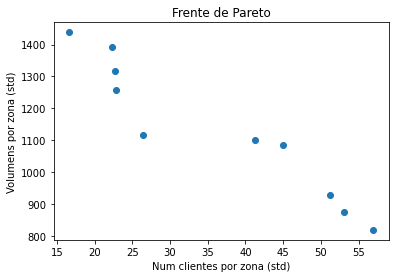

In [29]:
# Valores de número de nodos y volumen que alcanzan las soluciones en el frente pareto
plt.figure()
plt.scatter([x for x,y in pareto_front], [y for x,y in pareto_front])
plt.title('Frente de Pareto')
plt.xlabel('Num clientes por zona (std)')
plt.ylabel('Volumens por zona (std)')
plt.show()

In [27]:
# Evalua y las soluciones del frente pareto y las guarda en el formato de output requerido
for i in range(len(pareto_front)):
    klabs = pareto_data[i][1].numpy()
    client_id = data['Id_Cliente'].to_numpy().repeat(data['Frecuencia'].to_numpy(), axis=0)

    # Creación y guardado de la matriz de resultados
    results = np.zeros((len(data), 6))
    for Id, lab in zip(client_id, klabs):
        results[Id-1, lab] = 1

    results_df = pd.DataFrame(results)
    results_df.columns = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6']
    results_df['Id_Cliente'] = data['Id_Cliente']
    results_df = results_df[['Id_Cliente', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6']].astype(int)
    results_df.to_csv('pareto_%d.csv'%(i), header=True, index=False)

In [96]:
def real_dist(points):
    R = 6373.0
    points = torch.deg2rad(points)
    lat = points[:,0].unsqueeze(0)
    lon = points[:,1].unsqueeze(0)
    dlat = lat-lat.t()
    dlon = lon-lon.t()
    a = torch.sin(dlat/2)**2+torch.cos(lat)*torch.cos(lat.t())*torch.sin(dlon/2)**2
    c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
    return R*c

In [99]:
#Carga una matriz particular de resultados
results_df = pd.read_csv('pareto_58.csv')
results = results_df[['D1', 'D2', 'D3', 'D4', 'D5', 'D6']].to_numpy()
print('Número de clientes por zona (std): %5f'%(np.std(np.sum(results, axis=0))))

# Volumen Entregado como matriz de numpy
npvols = np.expand_dims(data['Vol_Entrega'].to_numpy(), 1)
delivered = results*npvols
print('Volumen entregado en cada zona (std): %5f'%(np.std(np.sum(delivered, axis=0))))

# Distancia recorrida por zona
dists = real_dist(points)
print('Distancias promedio por zona:')
for i in range(6):
    indices = np.where(klabs==i)
    curr_dists = dists[indices][:,indices]
    mean_dist = curr_dists.mean()/2
    print('Zona %d: %5f'%(i, mean_dist.item()))

Número de clientes por zona (std): 23.856632
Volumen entregado en cada zona (std): 1229.073688
Distancias promedio por zona:
Zona 0: 43.613763
Zona 1: 42.728377
Zona 2: 51.605172
Zona 3: 44.018752
Zona 4: 40.230263
Zona 5: 43.540115


In [63]:
# Construye los datos para mostrar en el mapa
labels = np.concatenate([np.where(results[i]!=0)[0] for i in range(results.shape[0])], axis=0)
orig_points = data[['lat', 'lon']].to_numpy().repeat(data['Frecuencia'], axis=0)
plot_df = pd.DataFrame({'lat':orig_points[:,0], 'lon':orig_points[:,1], 'zonas':labels.astype(str)})

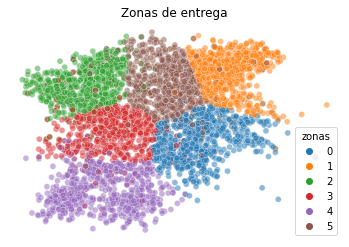

In [74]:
plt.figure()
sns.scatterplot(data=plot_df, x='lat', y='lon',
                hue='zonas', hue_order =['0', '1','2','3','4','5'],alpha=0.5)
sns.despine(left=True, bottom=True, right=True)
plt.title('Zonas de entrega')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.savefig('zonas.png')
plt.show()